# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go 
from plotly.offline import iplot


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline  # chaining step together

import warnings
warnings.filterwarnings('ignore')

# Read the Dataset

In [2]:
df = pd.read_csv('bank-full.csv', sep = ';')
df.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# Check the duplicate

In [4]:
print(df.duplicated().value_counts())

False    45211
dtype: int64


# Descriptive Overview

In [5]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.94,10.62,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.27,3044.77,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.81,8.32,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.16,257.53,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.76,3.10,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.20,100.13,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.58,2.30,0.0,0.0,0.0,0.0,275.0


# Target value

In [6]:
df.rename(columns = {'y':'deposit'}, inplace = True)

df['deposit'] = df['deposit'].map( {'yes':1 ,'no':0}) 

df['deposit'].value_counts()/len(df)

0    0.883015
1    0.116985
Name: deposit, dtype: float64

In [7]:
df.groupby('deposit').mean()

,age,balance,day,duration,campaign,pdays,previous
deposit,,,,,,,
0,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
1,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


**Observations**:

- The average Age & Balance of customers who have the term deposit is **higher** than the customers who didn’t.


- The Day seems not impact on target. need to be drop in next part.


- The Avg duration of call with those getting deposit is higher than the customers who didnt get the deposit.


- The campaigns are lower for customers who get the term deposit, means less contact probabaly increase the ratio of deposit.


- The pdays is lower for the customers who get the deposit.which make sense, since they can remember easier as fewer days passed


- The Previous( number of contacts performed before this campaign ) is higher for those get deposit.

# Target value Distribution

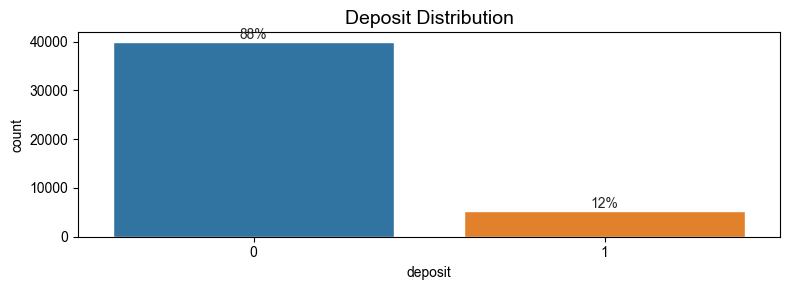

In [8]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.set_style('whitegrid')

sns.countplot(x=df['deposit'], ax=ax)

abs_vals = df['deposit'].value_counts()
rel_vals = df['deposit'].value_counts(normalize=True) * 100
labels = [f'{p[1]:.0f}%' for p in zip(abs_vals, rel_vals)]

ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Deposit Distribution', fontsize=14)
plt.tight_layout()

- The number of customers who have subscribed deposits is 5289 (12%)  


- The number of customers who do not subscribe deposits is 39922 (88%)


- The data is imbalanced and skewed(lead to false negatives)

#  Numerical Features Overview

In [9]:
Numeric_data = df.select_dtypes(include='number').columns.tolist()
#df[Numeric_data]

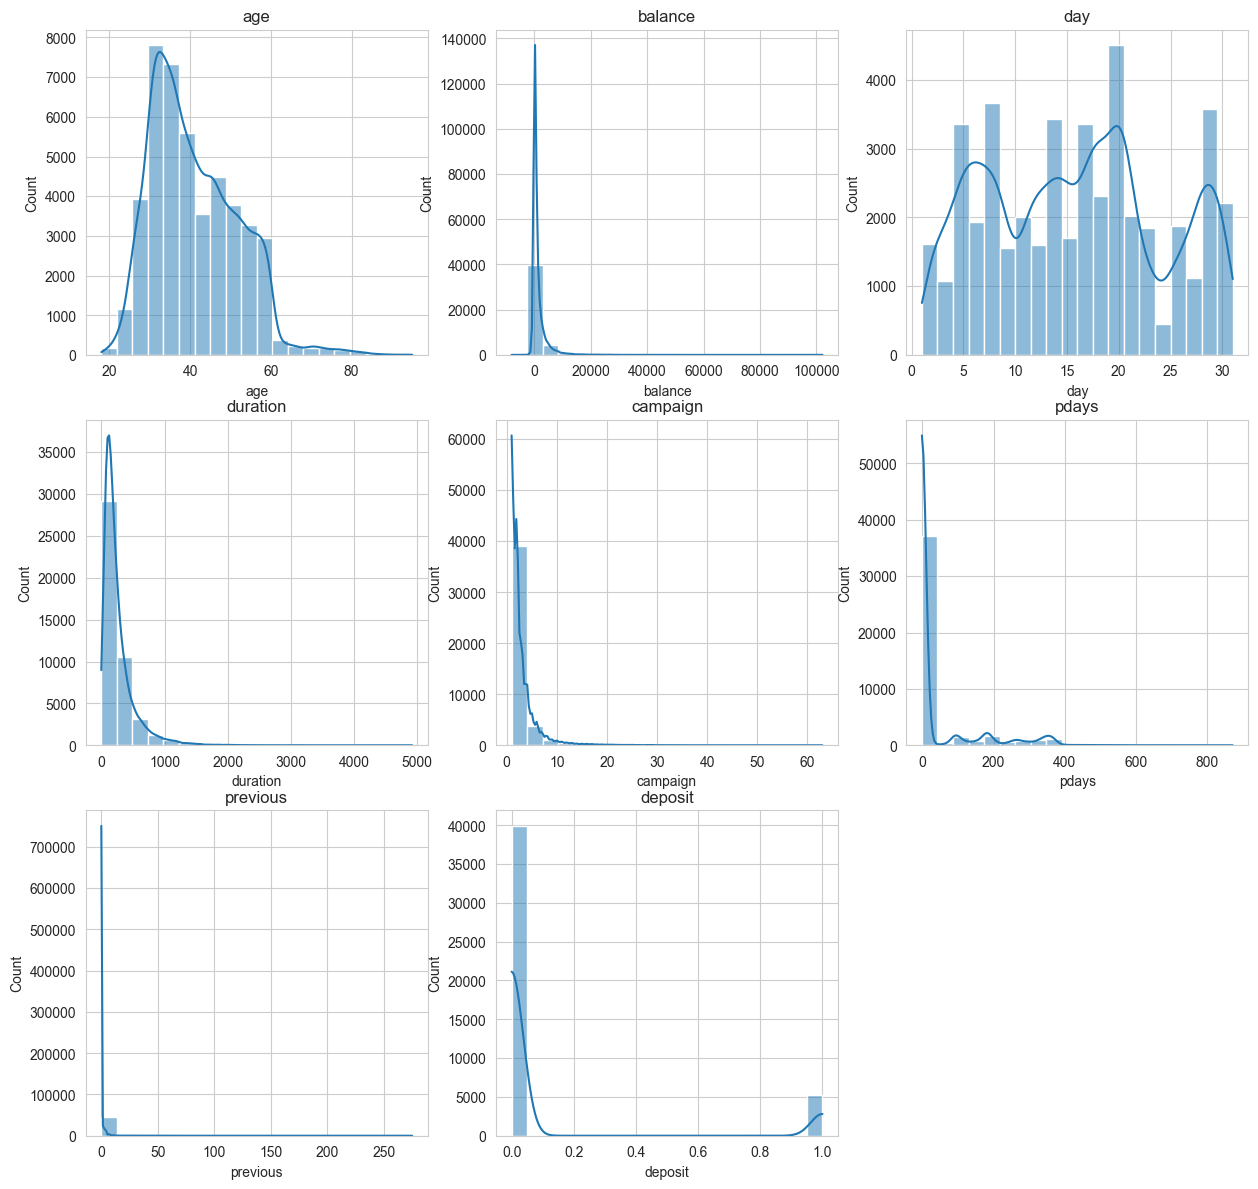

In [10]:
#Numerical features overview 2
plt.figure(figsize=(15,60))

plotnum =1
for i in Numeric_data:
    ax = plt.subplot(12,3,plotnum)
    #sns.histplot(data=df,x=i,kde=True, bins=20)
    sns.histplot(df[i],kde=True, bins=20)
    plt.xlabel(i)
    plt.title(i)
    plotnum+=1
plt.show()

- Most of the numerical features (Balance, duration, compaign, pdays and previous) have **right skewed** and have some **outliers**  which need to be removed in the nest part.


- Age, Days almost normally distributed


- Numeric features have **different scales**, need to be scale values before building ML model.

# Categorical features Overview

### Deposit by Job,Marital and Education

Text(0.5, 1.0, 'Education Distribution')

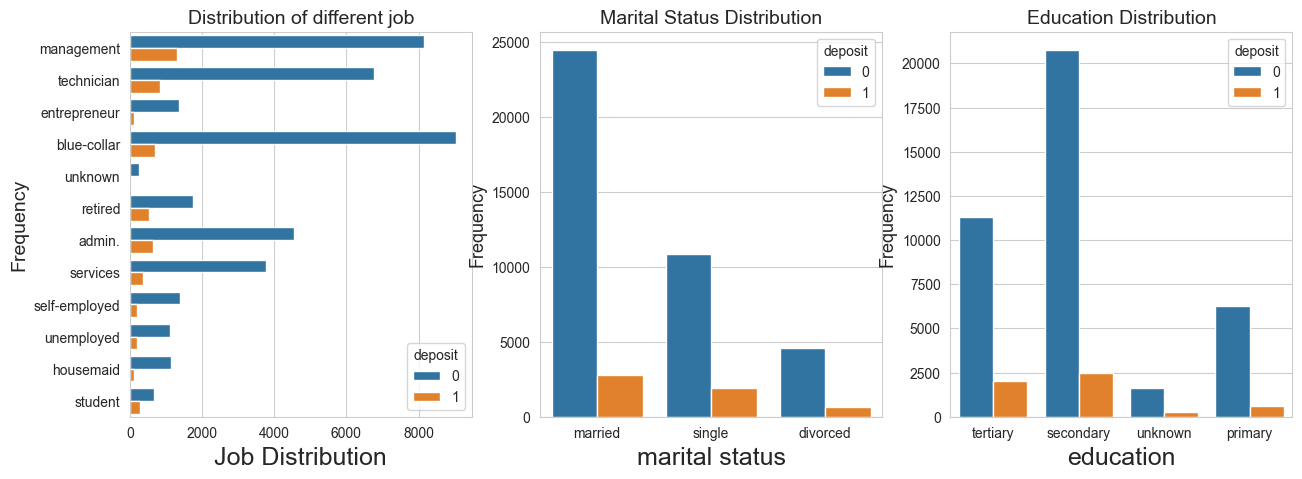

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))

ax = sns.countplot(y='job', hue='deposit', data=df, ax=ax1)
ax.set_xlabel('Job Distribution', fontsize=18)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Distribution of different job', fontsize = 14)

ax = sns.countplot(x='marital', hue='deposit', data=df, ax=ax2)
ax.set_xlabel('marital status', fontsize=18)
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_title('Marital Status Distribution', fontsize = 14)

ax = sns.countplot(x='education', hue='deposit', data=df, ax=ax3)
ax.set_xlabel('education',fontsize = 18)
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_title('Education Distribution', fontsize = 14)

### Deposit by Default,Housing and Loan

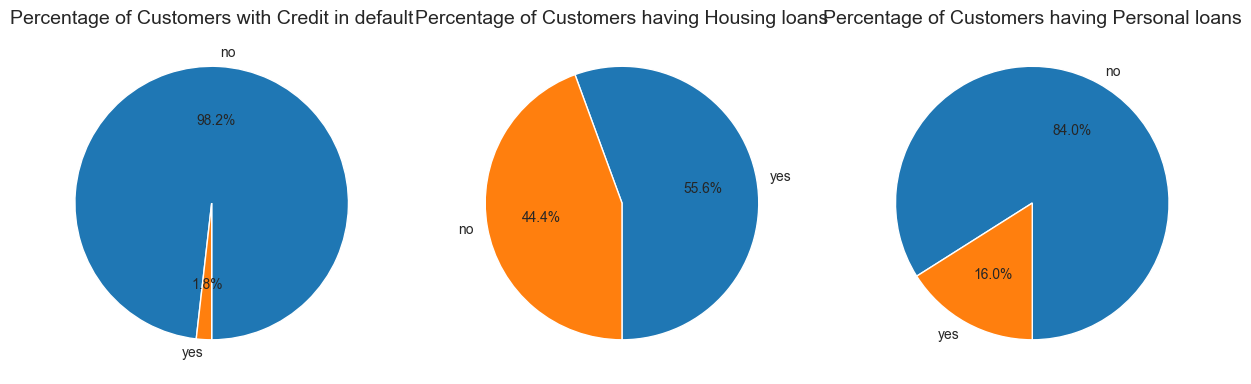

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
labels =df['default'].value_counts().index
sizes = df['default'].value_counts()
plt.pie(sizes,labels=labels,autopct='%1.1f%%', startangle=270)
plt.title('Percentage of Customers with Credit in default',size = 14)

plt.subplot(1,3,2)
labels =df['housing'].value_counts().index
sizes = df['housing'].value_counts()
plt.pie(sizes,labels=labels,autopct='%1.1f%%', startangle=270)
plt.title('Percentage of Customers having Housing loans',size = 14)

plt.subplot(1,3,3)
labels =df['loan'].value_counts().index
sizes = df['loan'].value_counts()
plt.pie(sizes,labels=labels,autopct='%1.1f%%', startangle=270)
plt.title('Percentage of Customers having Personal loans',size = 14)
plt.show()

### Deposit by Contact, Month,Poutcome

Text(0.5, 1.0, ' outcome of the previous marketing campaign')

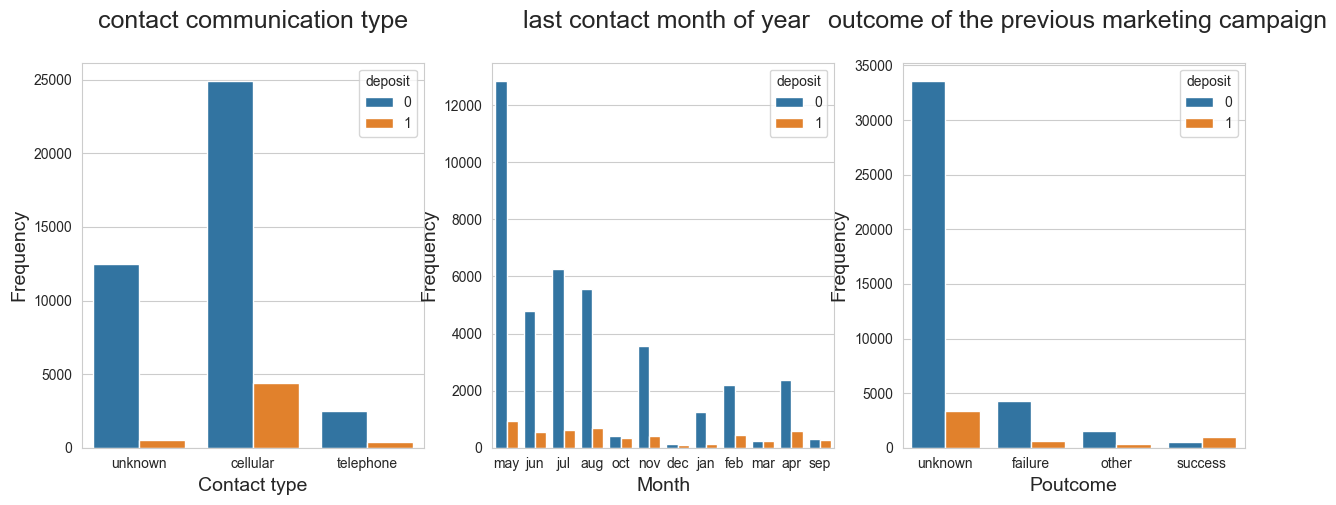

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))

ax = sns.countplot(x='contact', hue='deposit', data=df, ax=ax1)
ax.set_xlabel('Contact type', fontsize=14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('contact communication type', fontsize = 18,pad=25)

ax = sns.countplot(x='month', hue='deposit', data=df, ax=ax2)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title(' last contact month of year', fontsize = 18,pad=25)

ax = sns.countplot(x='poutcome', hue='deposit', data=df, ax=ax3)
ax.set_xlabel('Poutcome',fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title(' outcome of the previous marketing campaign', fontsize = 18,pad=25)

## First Overview Outcome

**Job**: Highest Number of applications are from management.

**Marital**: a maximum number of clients who approached were married.

**Education**: Clients with secondary and tertiary were approached more, and they had higher success rates. 
   (in terms of term deposit number)

**Default**: The default variable does not impact the client subscribing for a term deposit. So we will drop this feature.

**Housing**: A housing loan does not affect the number of term deposits purchased.

**Loan**: around 84% of clients with not have a personal loan.

**Contact**: Around 64% of calls are from cellular.

**Month**: May has the highest number of clients, and Dec has the lowest number. But the best ratio for deposits it's not    occure in May.

**Day**:  There is no significant difference in the number of clients approached and the number of people subscribed on a specific day.

**Poutcome**: If a client took the deposit last time, then there are higher chances of that client subscribing to it again.

## Categorical Features Overview in a for loop

In [14]:
#categorical_features = df.select_dtypes(include='object').drop('deposit').columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()
#categorical_features

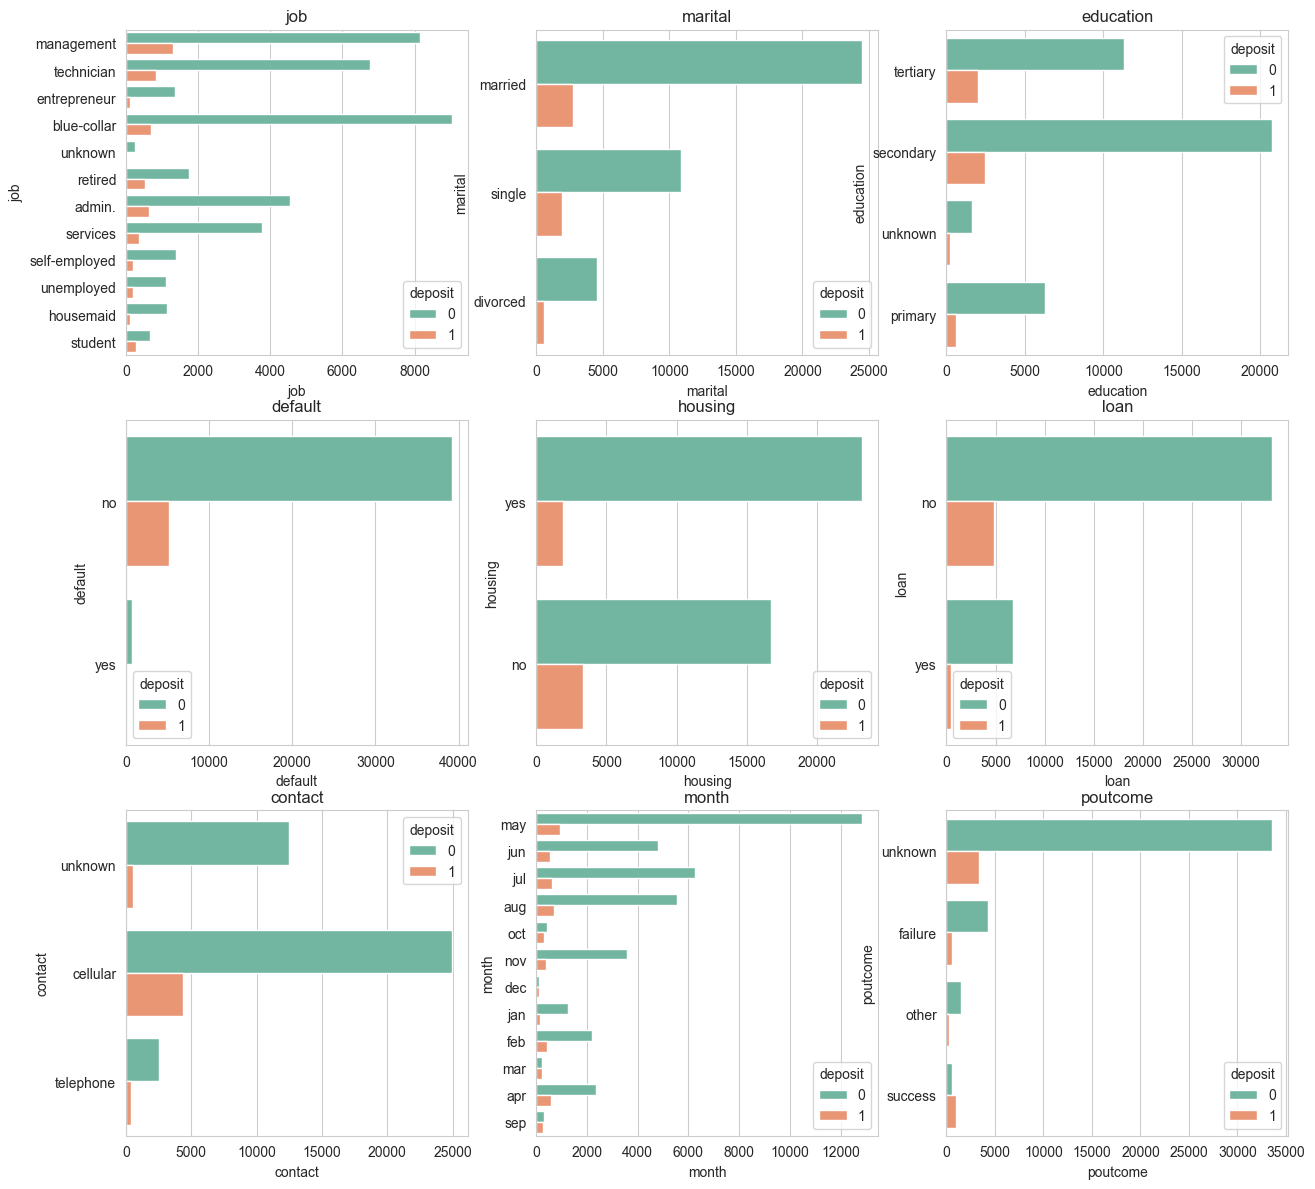

In [15]:
#categorical features
plt.figure(figsize=(15,60))
plotnumber =1
for cat_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=cat_feature, data=df ,hue='deposit',palette = 'Set2')
    plt.xlabel(cat_feature)
    plt.title(cat_feature)
    plotnumber+=1
plt.show()

# EDA

In [16]:
# Define a function to create a bar label on categorical plots

def label(data,feature,x,y):
    plt.figure(figsize=[x,y])
    sns.set_style('whitegrid')
    fig_deposit = sns.countplot(x=feature, hue='deposit', data = data, palette='pastel')
    fig_deposit.bar_label(fig_deposit.containers[0])
    fig_deposit.bar_label(fig_deposit.containers[1])

In [17]:
# Define a function to calculate the ratio in respect of deposit

def Ratio(feature):
    dep = df.groupby([feature])['deposit'].agg(['count', 'sum', 'mean']) 
    dep = dep.rename(columns = {'count':'Nr of Client','sum':'DeptSum', 'mean':'Ratio'}).sort_values(by='Ratio',ascending=False)
    return dep

## Job 

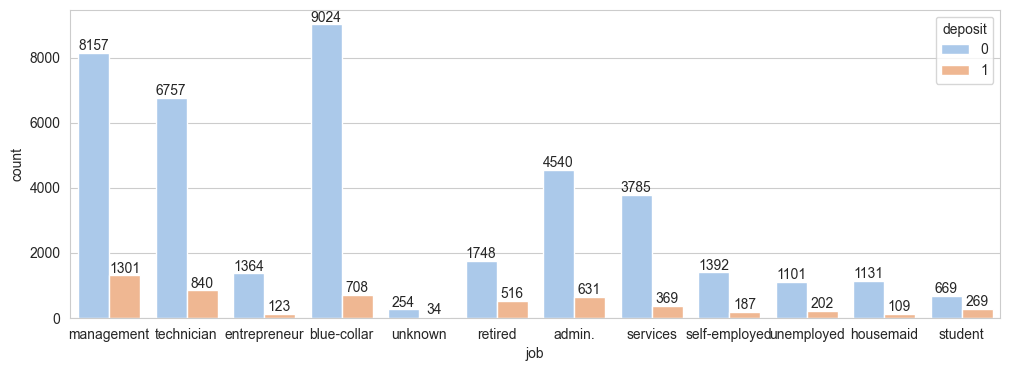

In [18]:
label(df,'job',12,4)

In [19]:
Ratio('job')

,Nr of Client,DeptSum,Ratio
job,,,
student,938,269,0.286780
retired,2264,516,0.227915
unemployed,1303,202,0.155027
management,9458,1301,0.137556
admin.,5171,631,0.122027
self-employed,1579,187,0.118429
unknown,288,34,0.118056
technician,7597,840,0.110570
services,4154,369,0.088830


## Marital

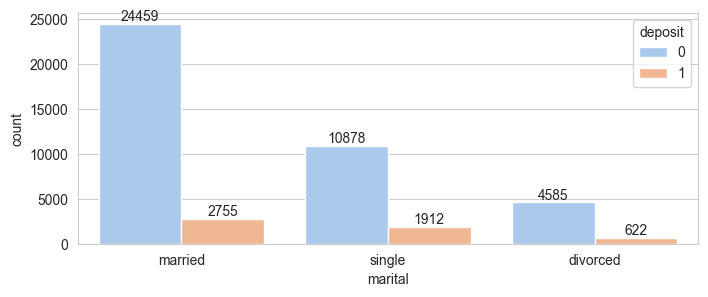

In [20]:
label(df,'marital',8,3)

In [21]:
Ratio('marital')

,Nr of Client,DeptSum,Ratio
marital,,,
single,12790,1912,0.149492
divorced,5207,622,0.119455
married,27214,2755,0.101235


- Even though the number of married customers is more, the single customer is close to getting the term deposit. 

## Education

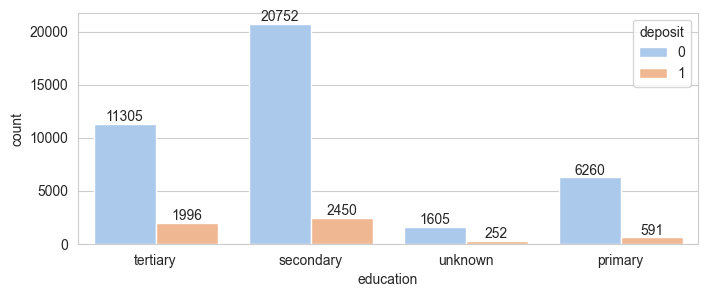

In [22]:
label(df,'education',8,3)

In [23]:
Ratio('education')

,Nr of Client,DeptSum,Ratio
education,,,
tertiary,13301,1996,0.150064
unknown,1857,252,0.135703
secondary,23202,2450,0.105594
primary,6851,591,0.086265


- clients with secondary levels are the highest proportion; however,
- tertiary level has the highest deposit customer percentage (15%).
- The trends go down with lower education. So the higher the education, the greater the tendency of a person to subscribe.

## Default

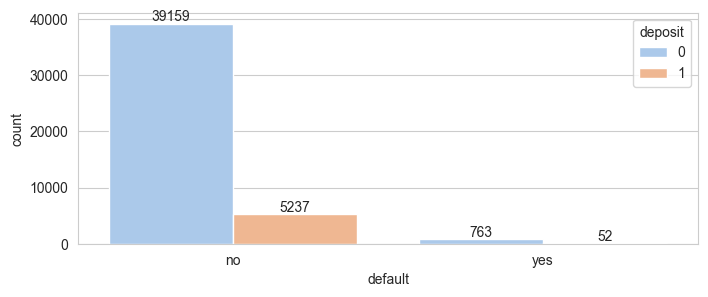

In [24]:
label(df,'default',8,3)

In [25]:
Ratio('default')

,Nr of Client,DeptSum,Ratio
default,,,
no,44396,5237,0.117961
yes,815,52,0.063804


## Housing

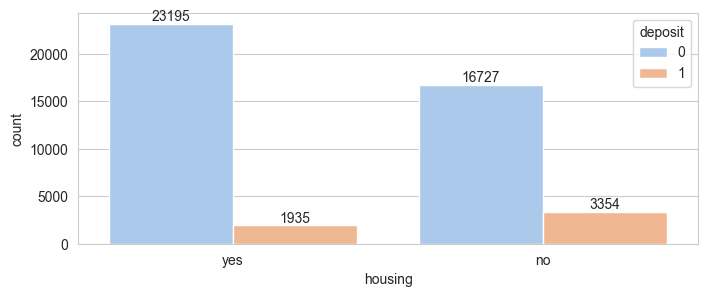

In [26]:
label(df,'housing',8,3)

In [27]:
Ratio('housing')

,Nr of Client,DeptSum,Ratio
housing,,,
no,20081,3354,0.167024
yes,25130,1935,0.077000


## loan

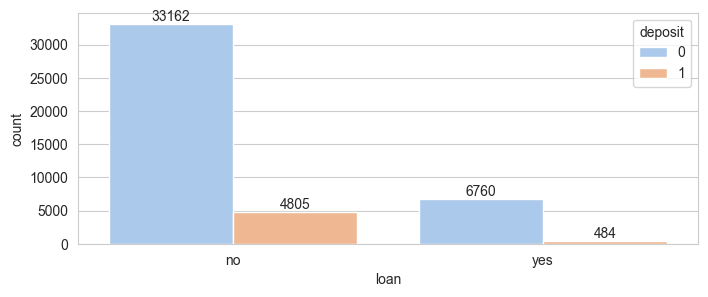

In [28]:
label(df,'loan',8,3)

In [29]:
Ratio('loan')

,Nr of Client,DeptSum,Ratio
loan,,,
no,37967,4805,0.126557
yes,7244,484,0.066814


- Clients with **no** Credit in default or not having Housing loans or not having Personal loans have twice the tendency to subscribe to a deposit compared to ones with default or loans.

## contact

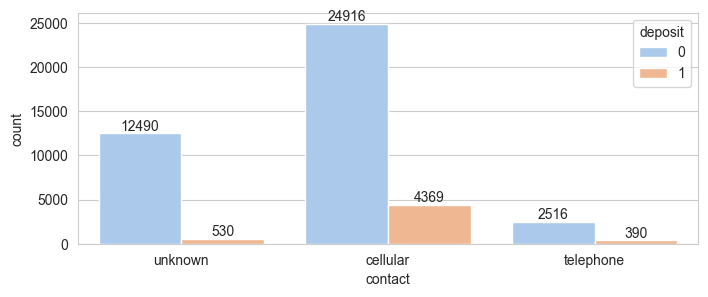

In [30]:
label(df,'contact',8,3)

In [31]:
Ratio('contact')

,Nr of Client,DeptSum,Ratio
contact,,,
cellular,29285,4369,0.149189
telephone,2906,390,0.134205
unknown,13020,530,0.040707


- Contacting clients by cellular or telephone does not dramatically impact the deposit in the end.
- Clients contacted by unknown contacts are more likely to **not** deposit; only 4% of them deposited.
- Should check what unknown means here

## Month

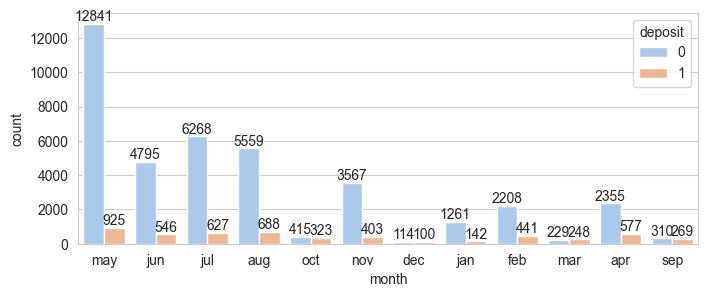

In [32]:
label(df,'month',8,3)

In [33]:
Ratio('month').T

month,mar,dec,sep,oct,apr,feb,aug,jun,nov,jan,jul,may
Nr of Client,477.000000,214.00000,579.000000,738.000000,2932.000000,2649.000000,6247.000000,5341.000000,3970.000000,1403.000000,6895.000000,13766.000000
DeptSum,248.000000,100.00000,269.000000,323.000000,577.000000,441.000000,688.000000,546.000000,403.000000,142.000000,627.000000,925.000000
Ratio,0.519916,0.46729,0.464594,0.437669,0.196794,0.166478,0.110133,0.102228,0.101511,0.101212,0.090935,0.067195


- Although the number of clients was high in **May** in compare with other months but the **deposit ratio** was the **lowest**

## poutcome

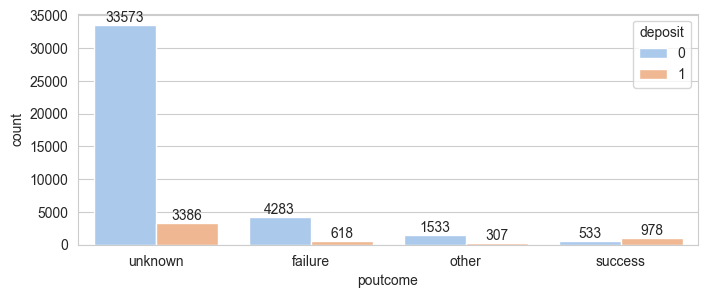

In [34]:
label(df,'poutcome',8,3)

In [35]:
Ratio('poutcome')

,Nr of Client,DeptSum,Ratio
poutcome,,,
success,1511,978,0.647253
other,1840,307,0.166848
failure,4901,618,0.126097
unknown,36959,3386,0.091615


# Further EDA on some Features

In [36]:
# Pandas group by column find percentage of count in each group

In [37]:
# df.groupby(['job','deposit']).count().reset_index()

### Deposit across Different Job

In [38]:
df1 = df.groupby(['job','deposit']).count().reset_index()
df1.loc[:,'percentage'] = list(df1.groupby(['job'])['age'].apply(lambda x: round(x*100/x.sum())))
df1 = df1[df1.deposit==1]
#df1.percentage

<Axes: xlabel='job', ylabel='percentage'>

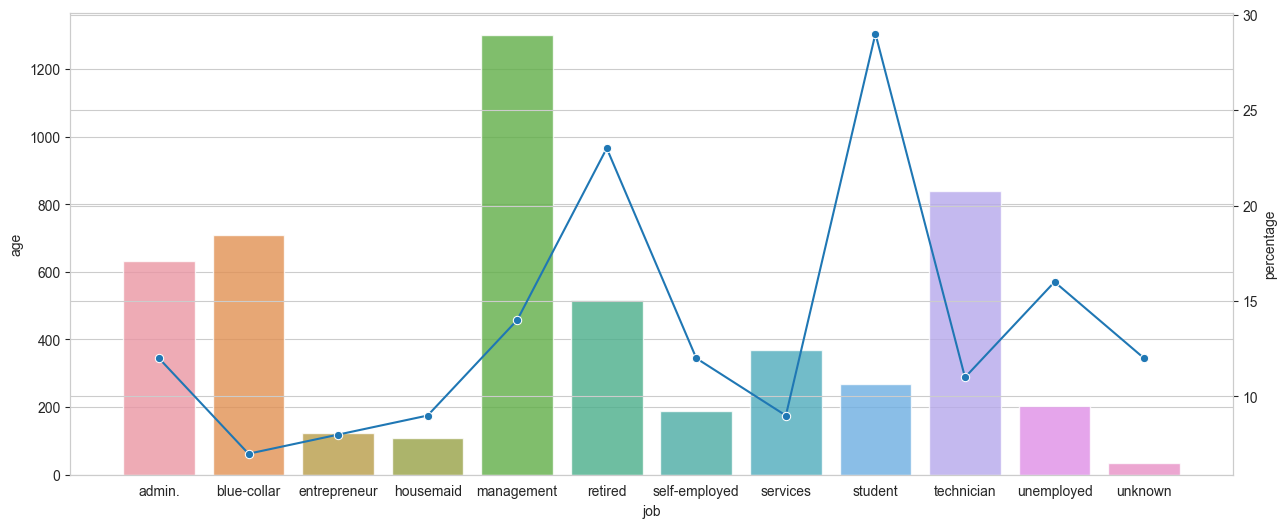

In [39]:
fig, ax1 = plt.subplots(figsize=(15,6))

#sns.countplot(data = df, x='job', alpha=0.8, ax=ax1)
sns.barplot(data = df1, x='job', y= 'age', alpha=0.8, ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(data =df1, x='job', y='percentage', marker='o', sort = True,ax=ax2)

### Deposit across contanct type

In [40]:
df2 = df.groupby(['contact','deposit']).count().reset_index()
df2.loc[:,'percentage'] = list(df2.groupby(['contact'])['age'].apply(lambda x: round(x*100/x.sum())))
df2 = df2[df2.deposit==1]

<Axes: xlabel='contact', ylabel='percentage'>

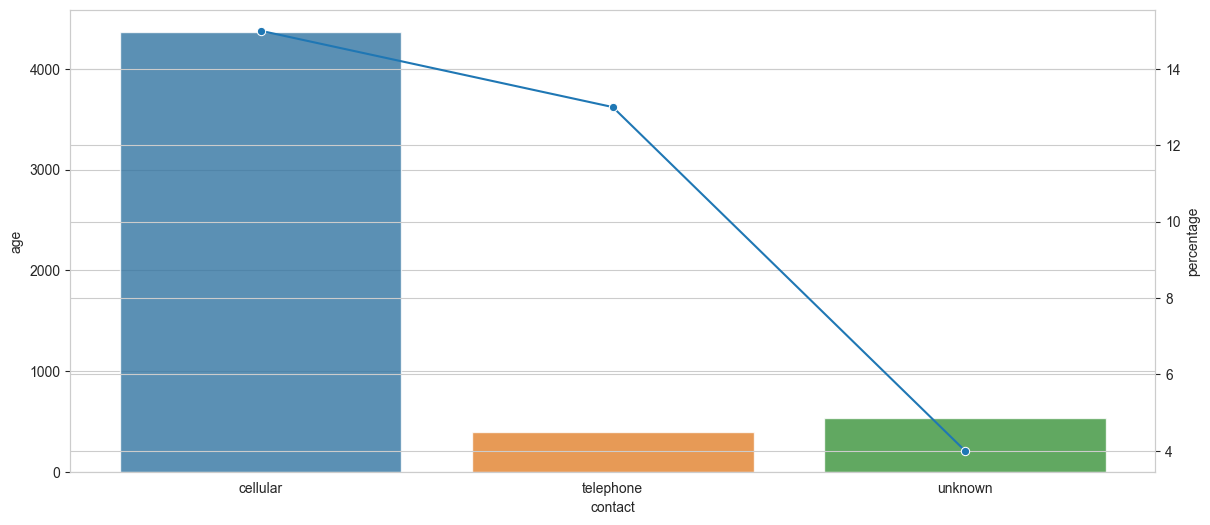

In [41]:
fig, ax1 = plt.subplots(figsize=(14,6))

sns.barplot(data = df2, x='contact',y='age' ,alpha=0.8, ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data =df2, x='contact', y='percentage', marker='o', sort = True,ax=ax2)

### Deposit across different month

In [42]:
df3 = df.groupby(['month','deposit']).count().reset_index()
df3.loc[:,'percentage'] = list(df3.groupby(['month'])['age'].apply(lambda x: round(x*100/x.sum())))
df3 = df3[df3.deposit==1]

<Axes: xlabel='month', ylabel='percentage'>

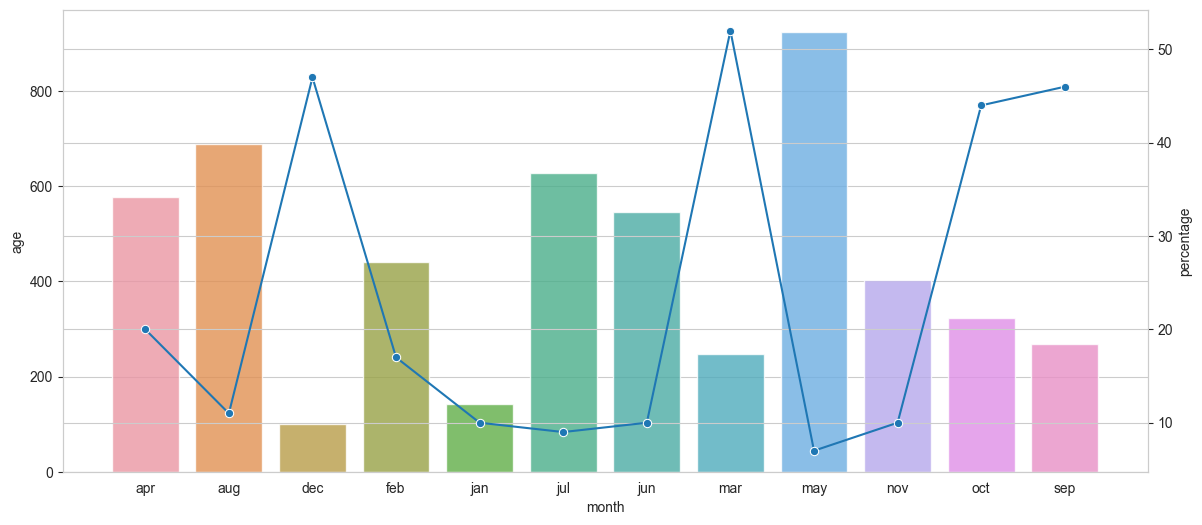

In [43]:
fig, ax1 = plt.subplots(figsize=(14,6))

sns.barplot(data = df3, x='month',y='age',alpha=0.8, ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data =df3, x='month', y='percentage', marker='o', sort = True,ax=ax2)

### Deposit across different poutcome

In [44]:
df4 = df.groupby(['poutcome','deposit']).count().reset_index()
df4.loc[:,'percentage'] = list(df4.groupby(['poutcome'])['age'].apply(lambda x: round(x*100/x.sum())))
df4 = df4[df4.deposit==1]

<Axes: xlabel='poutcome', ylabel='percentage'>

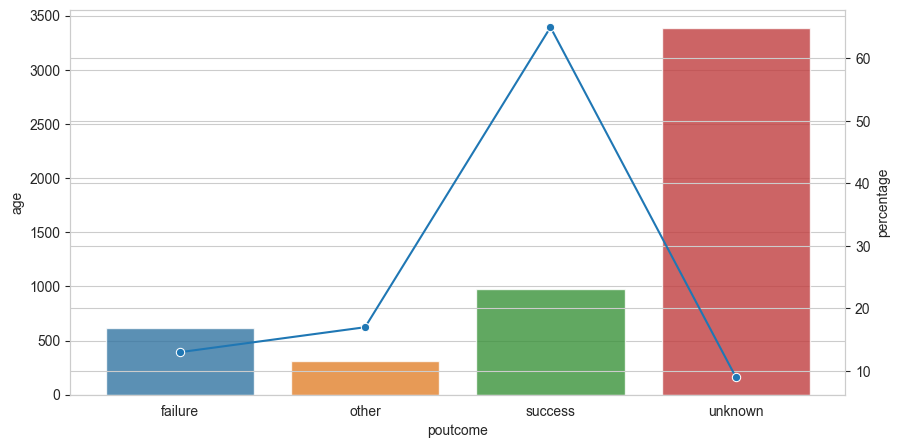

In [45]:
fig, ax1=plt.subplots(figsize=(10,5))

sns.barplot(data=df4, x='poutcome',y='age',alpha=0.8, ax=ax1)
ax2 =ax1.twinx()
sns.lineplot(data=df4,x='poutcome',y='percentage', marker='o', sort = True,ax=ax2)

### Deposit across different marital status

In [46]:
df5 = df.groupby(['marital','deposit']).count().reset_index()
df5.loc[:,'percentage'] = list(df5.groupby(['marital'])['age'].apply(lambda x: round(x*100/x.sum())))
df5 = df5[df5.deposit==1]

<Axes: xlabel='marital', ylabel='percentage'>

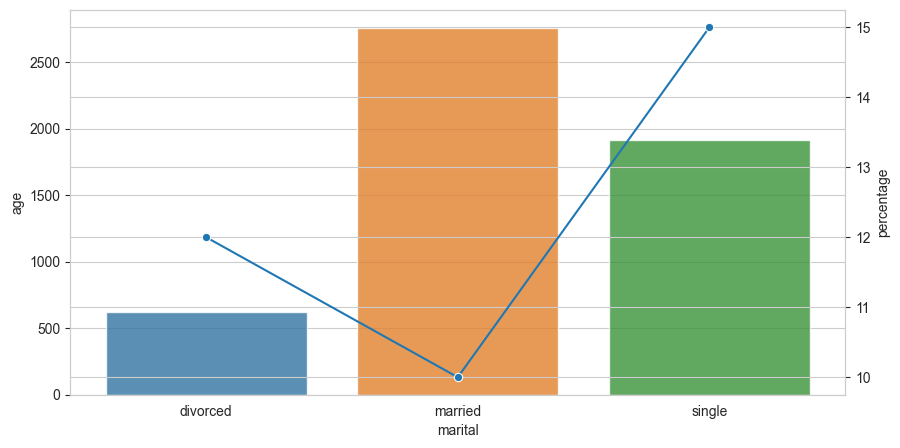

In [47]:
fig, ax1=plt.subplots(figsize=(10,5))

sns.barplot(data=df5, x='marital',y='age',alpha=0.8, ax=ax1)
ax2 =ax1.twinx()
sns.lineplot(data=df5,x='marital',y='percentage', marker='o', sort = True,ax=ax2)

### Deposit across different educational level

In [48]:
df6 = df.groupby(['education','deposit']).count().reset_index()
df6.loc[:,'percentage'] = list(df6.groupby(['education'])['age'].apply(lambda x: round(x*100/x.sum())))
df6 = df6[df6.deposit==1]

<Axes: xlabel='education', ylabel='percentage'>

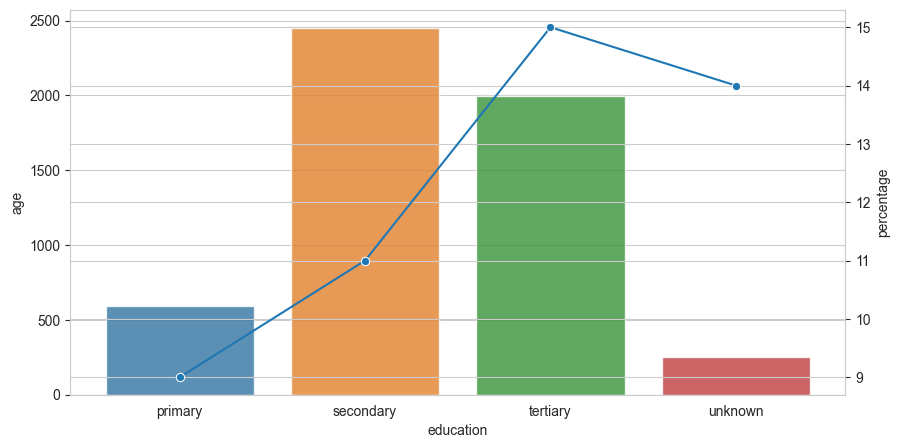

In [49]:
fig, ax1=plt.subplots(figsize=(10,5))

sns.barplot(data=df6, x='education',y='age',alpha=0.8, ax=ax1)
ax2 =ax1.twinx()
sns.lineplot(data=df6,x='education',y='percentage', marker='o', sort = True,ax=ax2)

**Observations**

- **job**:  **Students & Retired** are more likely to subscribe a term deposit respectively.**blueCollar** are the lowest in subcribing the term deposit.


- **Contact**: contacting through **Cellular** leads to subscribe abit  more deposit in compare to telephone but not dramatically different, hence this feature could be drop in the next part.
- On the other hand, customers contacted by unknown contacts are more likely to **not** deposit; only 4% of them deposited. the unknown does not define in the dataset.


- **Month**: **March** & **December** have the **highest** ratio of subscribing a term deposit and **May** is the **lowest** month, unlike the number of customers are much more in May but the subscribtion is the lowest.


- **Poutcome**: The **successful previous campaign** will lead to a higher percentage of clients who accepts the subscription for a term deposit.


- **Marital Status** : **Single** customers are 4% more likley to subsribe the term deposit.


- **Education** : **Tertiary** Customers are two times more probabale to get the term deposit.

# EDA on Numerical Feature 

# Age

## Age Distribution in Getting Deposit Vs Not Getting Deposit

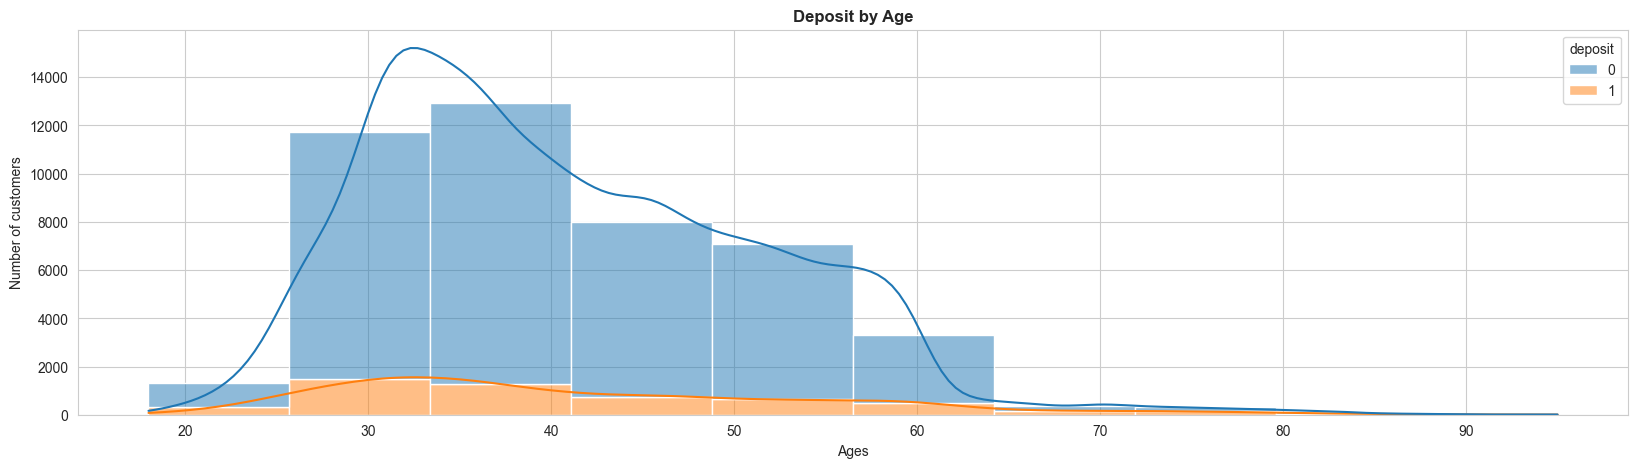

In [50]:
fig = plt.figure(figsize= (20,5))
dep_by_age = sns.histplot(data = df, x = 'age', hue = 'deposit',multiple='stack', bins=10,kde=True,element='bars')

dep_by_age.set_ylabel('Number of customers')
dep_by_age.set_xlabel('Ages')
dep_by_age.set_title('Deposit by Age',weight='bold')
plt.show()

**Observation**:
    
- Deposit starts at the age of 20+ and peack is between 30-50. 


- Frequntly deposit age in getting deposit or not is 35.


- in addtion Non deposite age is between 30-50 years with mean is around 35-40 years

## binning the age to get more insight 

In [51]:
bins = [18, 30, 40, 60, 95]
labels = ['Youth', 'Young Adults', 'Mid-age Adults', 'Older']
df['agerange'] = pd.cut(df.age, bins=bins, labels = labels, include_lowest = True)
df.drop(columns = 'age')

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,agerange
0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,Mid-age Adults
1,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,Mid-age Adults
2,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,Young Adults
3,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,Mid-age Adults
4,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,Young Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1,Mid-age Adults
45207,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1,Older
45208,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1,Older
45209,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0,Mid-age Adults


In [52]:
df.agerange.value_counts(normalize=True)

Mid-age Adults    0.427020
Young Adults      0.391210
Youth             0.155493
Older             0.026277
Name: agerange, dtype: float64

In [53]:
Ratio('agerange')

,Nr of Client,DeptSum,Ratio
agerange,,,
Older,1188,502,0.422559
Youth,7030,1145,0.162873
Young Adults,17687,1812,0.102448
Mid-age Adults,19306,1830,0.094789


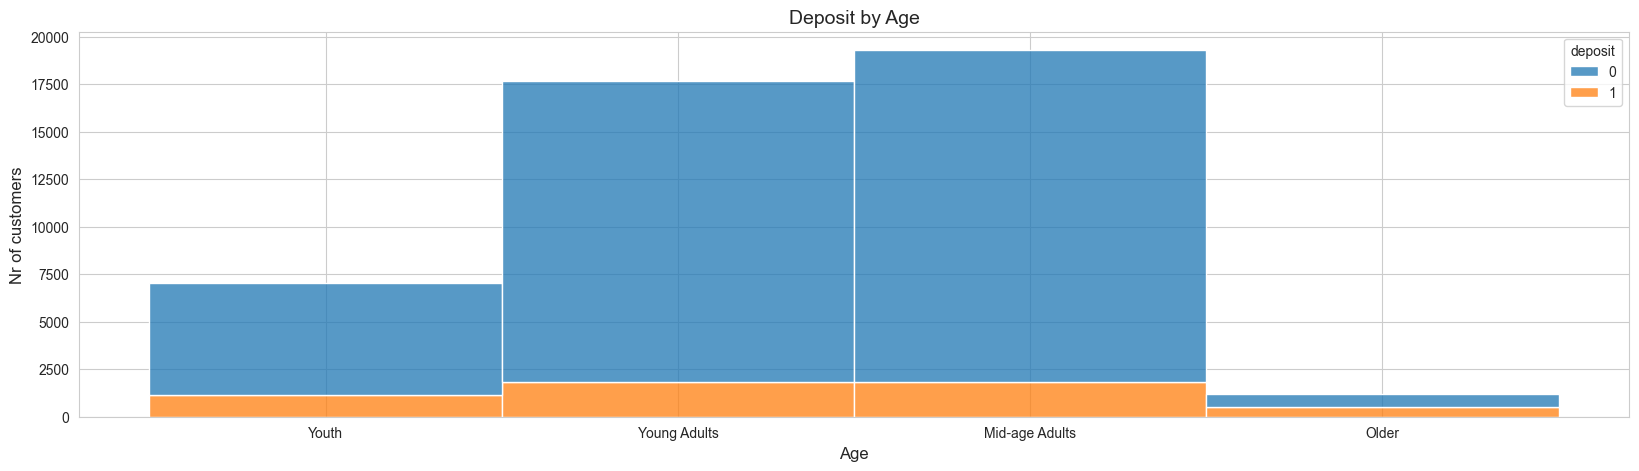

In [54]:
plt.figure(figsize=(20,5))
bins = [18, 30, 40, 60, 95]

age_range = sns.histplot(x = df['agerange'], hue = df['deposit'], multiple="stack",bins=bins)
age_range.set_ylabel('Nr of customers', fontsize = 12)
age_range.set_xlabel('Age', fontsize = 12)
age_range.set_title('Deposit by Age', fontsize = 14)
plt.show()

- Eventhough, the Elderly group, with relatively small quantity, has the highest percentage of deposit customers.


- Elder and Youth (students and retired) are more likely to subscribe


- Most client are Young and Middle-Aged People and they have not so high deposit percentages. 11% and 9% respectively.


## Distribution of age by job

Text(0.5, 1.0, 'Jobs by Age')

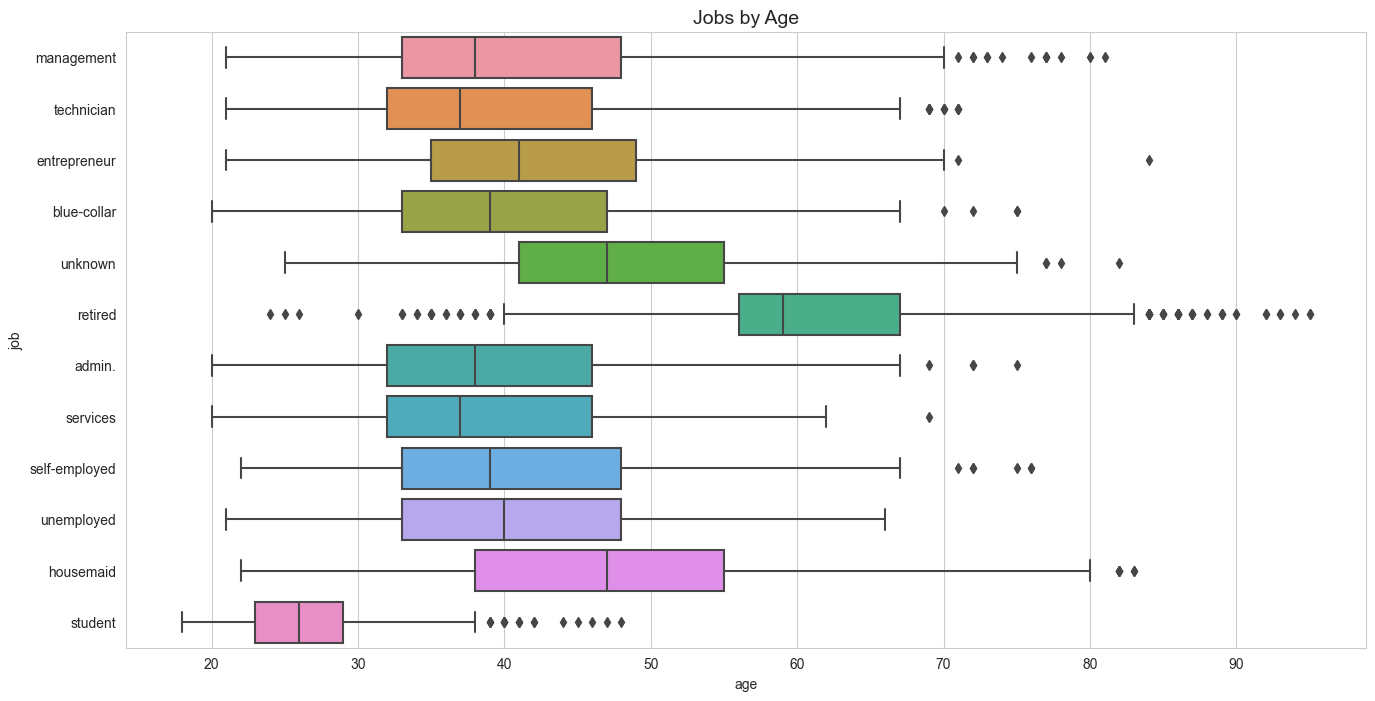

In [55]:
plt.figure(figsize=(16,8))
sns.set_style('whitegrid')
ax= sns.boxplot(x='age',y='job',data=df)
ax.set_title('Jobs by Age', fontsize = 14)

- All the job are almost around 35-55
- students between 25-30
- Retired are above 55

# Balance

In [56]:
df.balance.describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

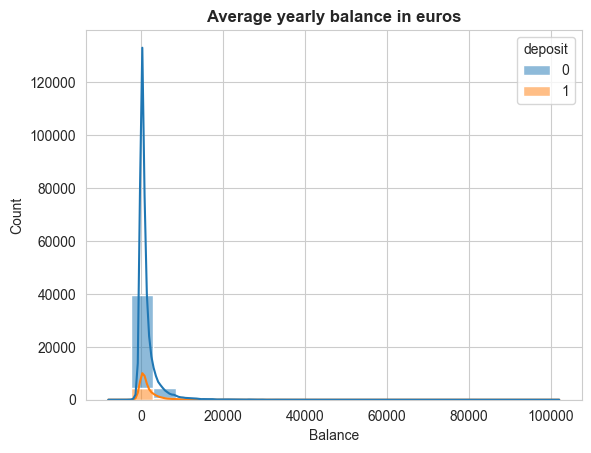

In [57]:
sns.histplot(data=df,x='balance',kde=True, bins=20,hue='deposit',multiple='stack')
plt.title('Average yearly balance in euros',weight='bold')
plt.xlabel('Balance')
plt.show()

- The balance shows a high standard deviation. In other words, we can say that the data points show a wide spread.the Mean and Median and Min-Max values show a distant from each other. so probably the data is not normally distributed and there may be outliers (scaling can be done with a min-max scaler).


- The average yearly balance of customers given is diverse and quite low, which is mostly less than €1000 per year.


# Balance & Age

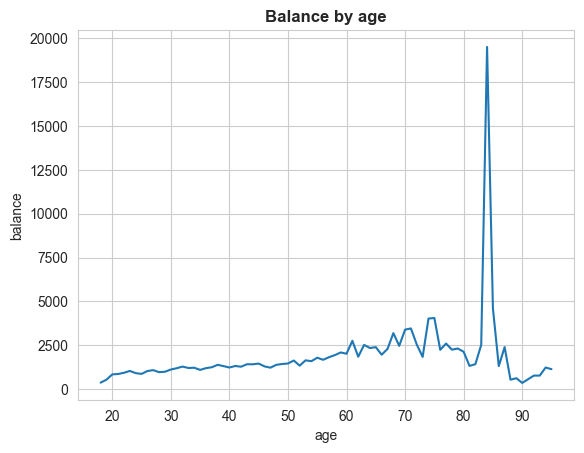

In [58]:
fig.set_size_inches(10,5)
plt.title('Balance by age',weight='bold')
plt.xlabel('age')
plt.ylabel('balance') 

plt.plot(df.groupby('age').mean()['balance'])

In [59]:
# df.groupby('age').mean()['balance'].to_frame().sort_values(by='age',ascending=False)

- Client in 70s and higher have the largest balance of around 2500 or most considerable at around 85s.
- Balance highly varied across age

# Balance & Job

Text(0.5, 1.0, 'Distribution of balace by Job')

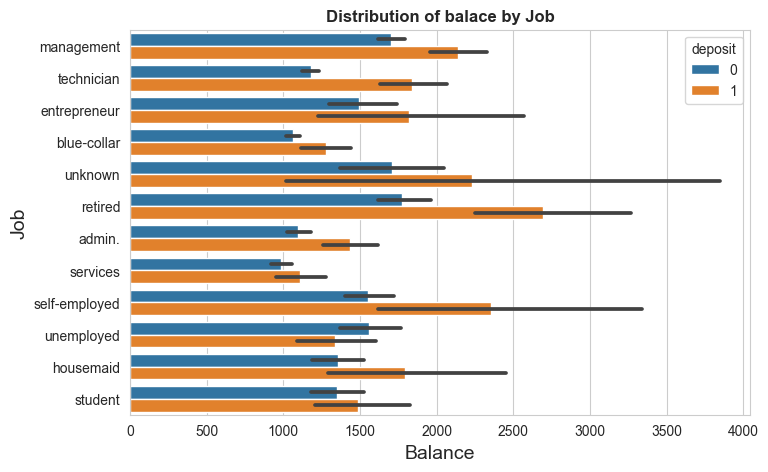

In [60]:
plt.figure(figsize=[8,5])

sns.barplot(data=df,y='job',x='balance',hue='deposit')

plt.xlabel('Balance',fontsize=14)
plt.ylabel('Job',fontsize=14)
plt.title('Distribution of balace by Job',weight='bold')

In [61]:
df.groupby(['job'])['balance'].mean().to_frame().sort_values(by='balance',ascending=False).T

job,retired,unknown,management,self-employed,unemployed,entrepreneur,housemaid,student,technician,admin.,blue-collar,services
balance,1984.215106,1772.357639,1763.616832,1647.970868,1521.745971,1521.470074,1392.395161,1388.060768,1252.632092,1135.838909,1078.826654,997.088108


- According to the graph, **Retired customers** have the **highest balance** value whereas the lowest value is occupied by those who do services.


- It is significant that people who holds **Management** position are **higher earners**, while administrators, blue-collar workers and services staff generally have low income.

<Axes: xlabel='balance', ylabel='job'>

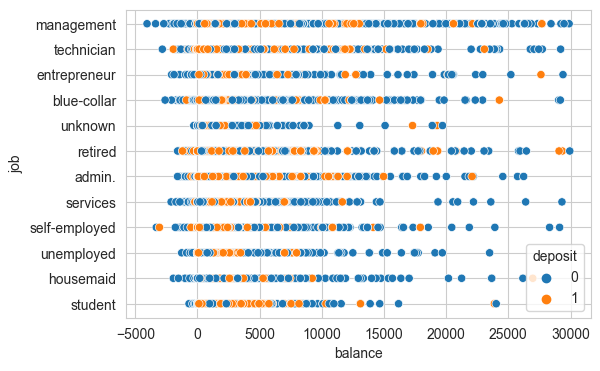

In [62]:
plt.figure(figsize=[6,4])
sns.scatterplot(data=df, y='job', x= df['balance'].loc[(df['balance']>=-5000)&(df['balance']<=30000)], hue='deposit')

<Axes: xlabel='Balance_seg'>

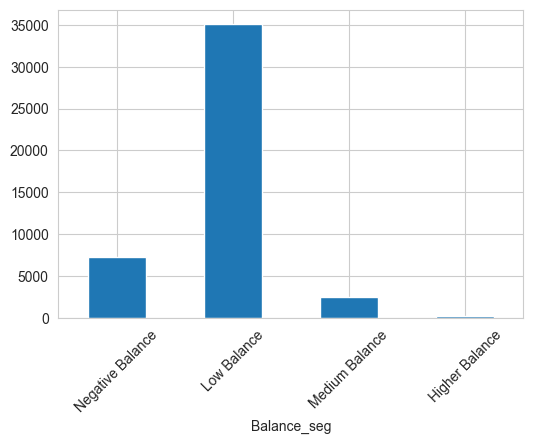

In [63]:
plt.figure(figsize=[6,4])
bins = [-5000,0,5000,15000,20000]
labels = ['Negative Balance','Low Balance','Medium Balance','Higher Balance']
df['Balance_seg'] = pd.cut(df.balance, bins=bins, labels =labels,include_lowest=True)
df.groupby('Balance_seg').Balance_seg.count().plot(kind='bar',rot=45)  
#df.drop(['balance'], axis = 1)

In [64]:
Ratio('Balance_seg')

,Nr of Client,DeptSum,Ratio
Balance_seg,,,
Medium Balance,2494,397,0.159182
Low Balance,35086,4346,0.123867
Higher Balance,158,15,0.094937
Negative Balance,7278,502,0.068975


- Customers with a 'medium balance' ~ 5000 -15000 income are more likely to term deposit than other groups

## Balance & Education

Text(0.5, 1.0, 'Distribution of Education by Balance')

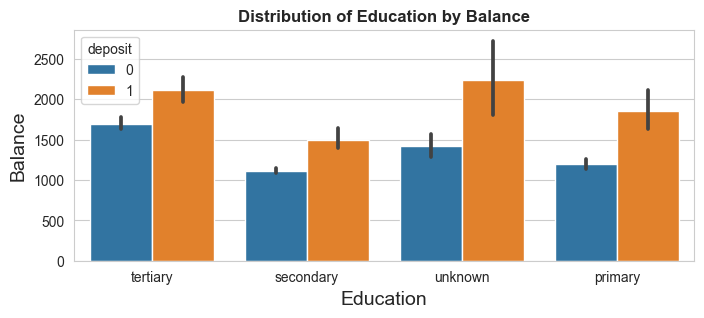

In [65]:
plt.figure(figsize=[8,3])
sns.set_style('whitegrid')
sns.barplot(data=df,y='balance',x='education',hue='deposit')


plt.xlabel('Education',fontsize=14)
plt.ylabel('Balance',fontsize=14)
plt.title('Distribution of Education by Balance',weight='bold')

In [66]:
Ratio('education')

,Nr of Client,DeptSum,Ratio
education,,,
tertiary,13301,1996,0.150064
unknown,1857,252,0.135703
secondary,23202,2450,0.105594
primary,6851,591,0.086265


- Apart from unknown group, which is not clear from dataset why it's called unknown, The Higher Education the higher balance 


- Cutomers with secondary levels are the highest proportion; however, tertiary level has the highest deposit customer percentage 

## Day

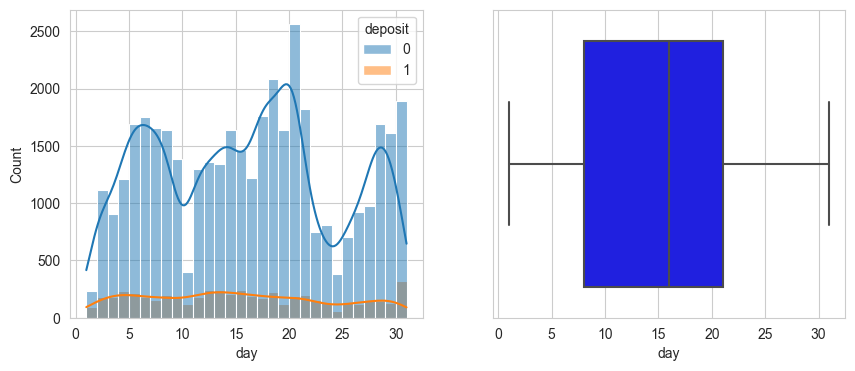

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,4)
sns.histplot(x='day', data=df, hue = 'deposit', bins=30, ax=ax[0],kde = True, color ='y')
sns.boxplot(x='day',data=df, ax=ax[1],color ='b')

plt.xlabel('day')
plt.show()

day,1,10,30,22,3,4,25,12,13,2,...,21,18,6,17,7,28,29,31,20,19
Nr of Client,322.000000,524.000000,1566.000000,905.000000,1079.000000,1445.00000,840.000000,1603.000000,1585.00000,1293.000000,...,2026.00000,2308.000000,1932.000000,1939.000000,1817.000000,1830.000000,1745.000000,643.00000,2752.000000,1757.000000
DeptSum,90.000000,121.000000,271.000000,154.000000,178.000000,230.00000,133.000000,244.000000,241.00000,182.000000,...,201.00000,228.000000,181.000000,176.000000,157.000000,143.000000,129.000000,46.00000,192.000000,122.000000
Ratio,0.279503,0.230916,0.173052,0.170166,0.164968,0.15917,0.158333,0.152215,0.15205,0.140758,...,0.09921,0.098787,0.093685,0.090768,0.086406,0.078142,0.073926,0.07154,0.069767,0.069437


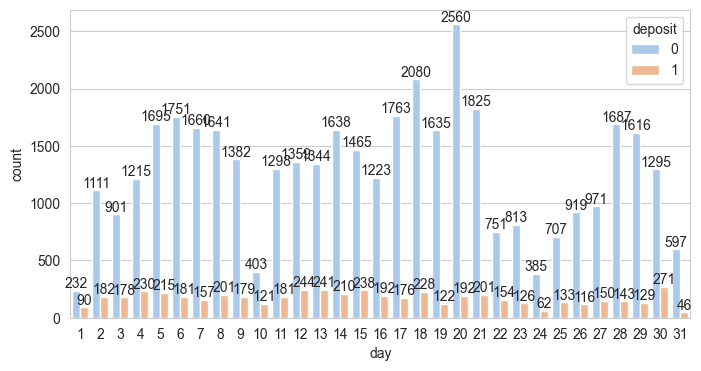

In [68]:
label(df,'day',8,4)
Ratio('day').T

- we will drop this feature as it's not add any information

# Duration (last contact duration, in seconds)

- this feature highly affects the output target (e.g., if duration=0, then deposit='no'). 
- the duration is not known before a call is performed. Also, after the end of the call, y(deposit) is known. 
- Thus, this input should only be included for benchmark purposes and discarded for the modeling section.

In [69]:
df.duration.describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

<Axes: xlabel='duration', ylabel='Count'>

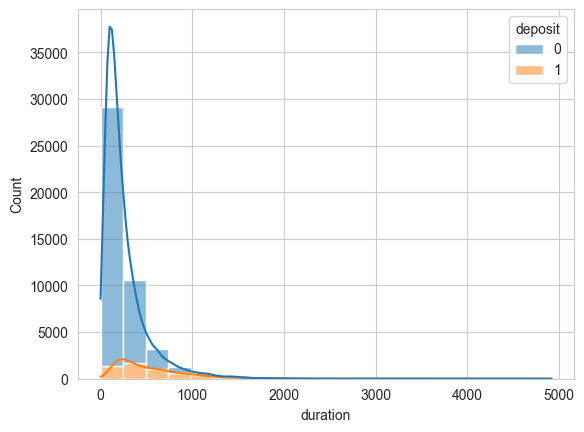

In [70]:
sns.histplot(data=df,x='duration',kde=True, bins=20,hue='deposit',multiple='stack')

<Figure size 800x300 with 0 Axes>

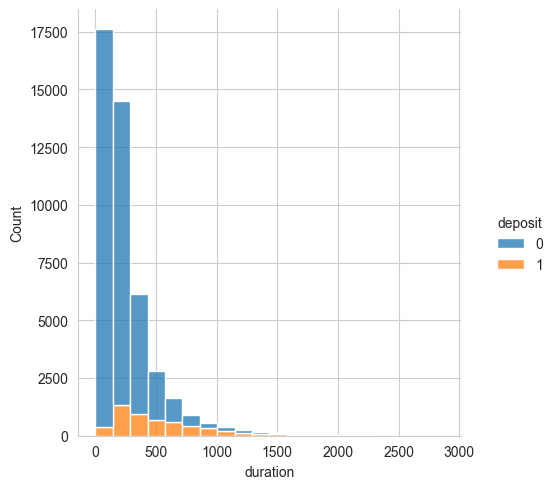

In [71]:
# plot without outlier
fig = plt.figure(figsize=[4,2])
fig.set_size_inches(8,3)
sns.displot(data=df, x=df['duration'].loc[df['duration']<=3000], hue='deposit', multiple='stack',bins=20)
plt.show()

# plot the boxplot to check the outliers

In [72]:
#df['call_range'] = pd.cut(df.duration, [0,1000,2000,3000, 4000, 5000], include_lowest=True, labels = [0,1,2,3,4])
bins= [0,1000,2000,3000]
labels = ['low','medium','high']
df['call_range'] = pd.cut(df.duration, bins=bins, labels =labels,include_lowest=True)
df.groupby('call_range').call_range.count()#.plot(kind='bar',rot=45)  
df.drop(['duration'], axis = 1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,agerange,Balance_seg,call_range
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,0,Mid-age Adults,Low Balance,low
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,0,Mid-age Adults,Low Balance,low
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,0,Young Adults,Low Balance,low
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,0,Mid-age Adults,Low Balance,low
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,0,Young Adults,Low Balance,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,1,Mid-age Adults,Low Balance,low
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,1,Older,Low Balance,low
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,1,Older,Medium Balance,medium
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,0,Mid-age Adults,Low Balance,low


- Highest duration occurs with the range from ~ 90-300.


- If the customer’s call duration is less than a minute, it is very obvious that there is no chance a customer will agree to place deposit.

,Nr of Client,DeptSum,Ratio
call_range,,,
medium,999,602,0.602603
high,45,24,0.533333
low,44153,4657,0.105474


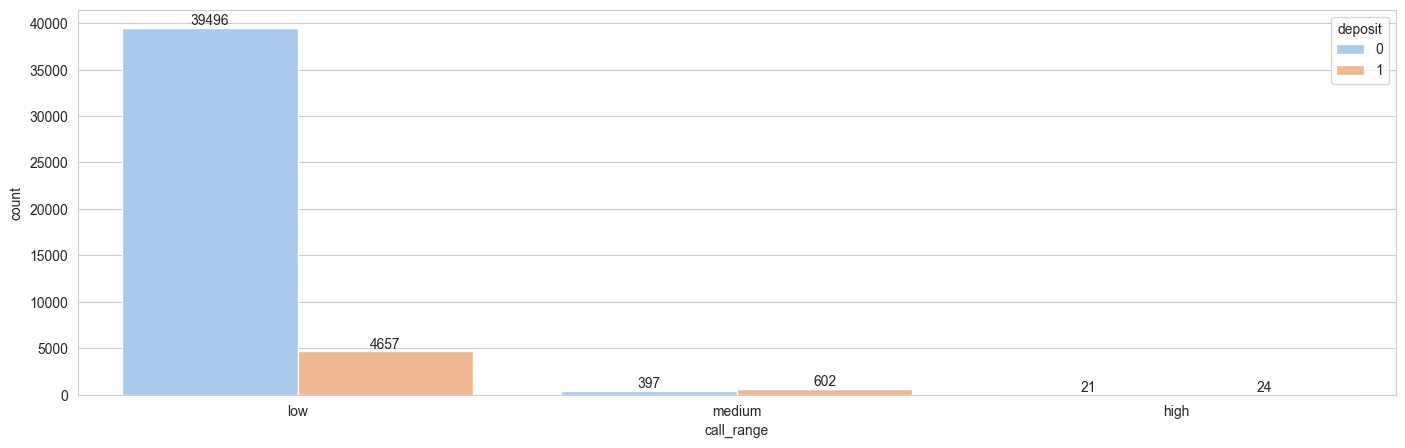

In [73]:
label(df,'call_range',17,5)
Ratio('call_range')

# Duration & Balance anf getting deposit

Text(0.5, 1.0, 'Relation Between duration and balance')

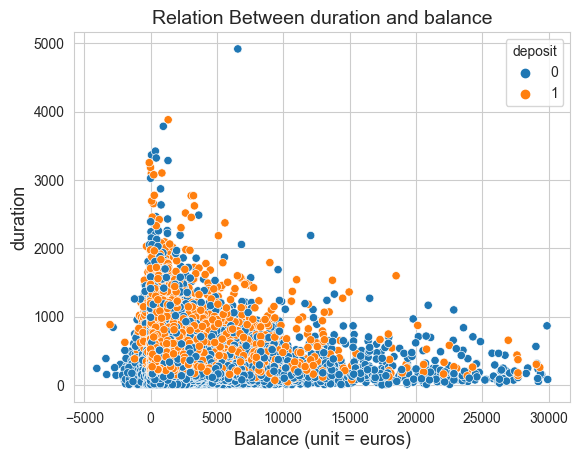

In [74]:
sns.scatterplot(data=df, y='duration', x= df['balance'].loc[(df['balance']>=-5000)&(df['balance']<=30000)], hue='deposit')

plt.ylabel('duration', fontsize = 13)
plt.xlabel('Balance (unit = euros)', fontsize = 13)
plt.title('Relation Between duration and balance', fontsize = 14)

- There is a tendency that longer the duration is, higher probability customers decide to subscribe a deposit, except for duration of over 3000, which seems to be outliers.

# Campaign

Outcome of previous marketing Campaign,number of contact :


<Axes: xlabel='campaign', ylabel='count'>

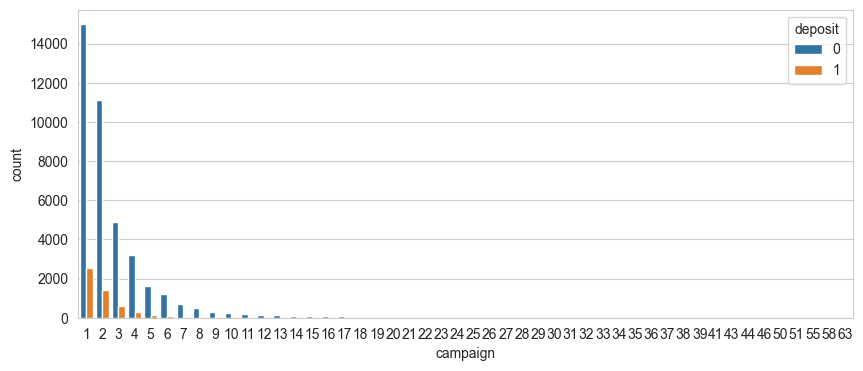

In [75]:
#  number of contacts performed during this campaign
print('Outcome of previous marketing Campaign,number of contact :')
fig=plt.figure(figsize=(10,4))
sns.countplot(data=df,x='campaign',hue='deposit')

# Relationship between campain and duration

<Axes: xlabel='campaign', ylabel='duration'>

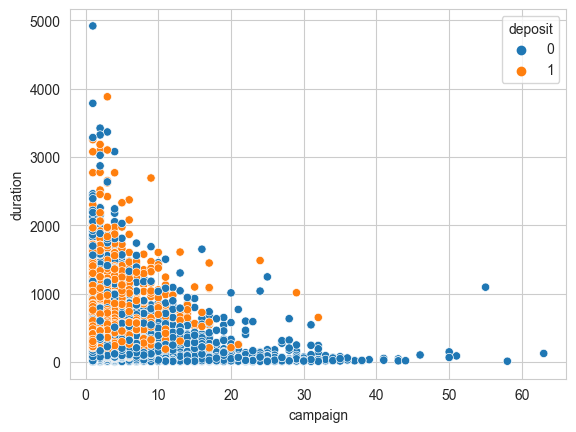

In [76]:
sns.scatterplot(x='campaign',y='duration',data=df ,hue='deposit')

- In a nutshell, more contacted in this campaign leads to **less subscribe**


- Based on above graph, customer who subscribed to term deposit chances are very few when the number of contacts performed is more than **20- 25**.


- Terefore, the bank no need to focus on customers who are already contacted at least 25 times.

In [77]:
df.campaign.describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [78]:
# binning the campaign
bins = [0,1,5,10,30,50,63]
labels =['1','2-5','6-10','11-30','31-50','51+']
df['binned_campaign'] = pd.cut(df['campaign'], bins=bins, labels=labels, include_lowest=True)
Ratio('binned_campaign')

,Nr of Client,DeptSum,Ratio
binned_campaign,,,
1,17544,2561,0.145976
2-5,23312,2475,0.106168
6-10,3159,206,0.065211
11-30,1137,46,0.040457
31-50,55,1,0.018182
51+,4,0,0.000000


- Less contact is increase the ratio of deposit

# Pdays

In [79]:
pd.cut(df['pdays'], bins=4).value_counts(normalize=True)

(-1.872, 217.0]    0.916923
(217.0, 435.0]     0.078963
(435.0, 653.0]     0.003141
(653.0, 871.0]     0.000973
Name: pdays, dtype: float64

In [80]:
df.pdays.describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

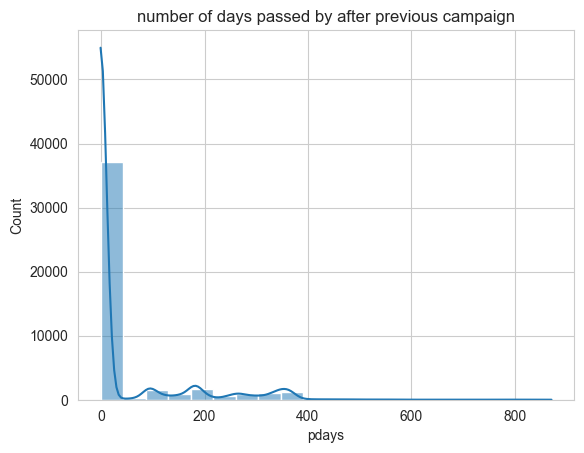

In [81]:
#  number of days that passed by after the client was last contacted from a previous campaign
fig.set_size_inches(2,2)
sns.histplot(data=df, x='pdays', kde = True, legend=True, bins=20)
plt.title('number of days passed by after previous campaign')
plt.xlabel('pdays')
plt.show()

<Axes: xlabel='pdays_range'>

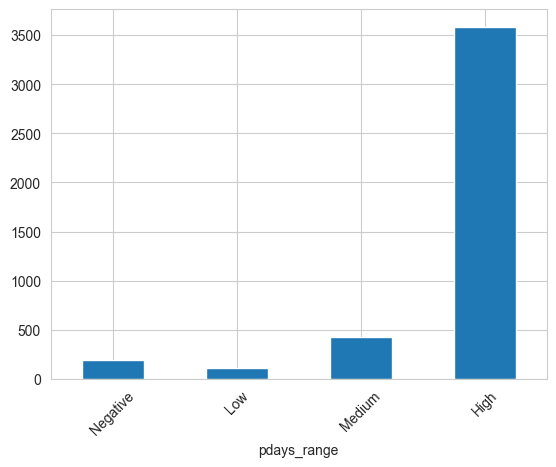

In [82]:
# divide pdays into 4 groups
bins = [-1, 30, 60, 90,200]
labels = ['Negative', 'Low', 'Medium','High']
df['pdays_range'] = pd.cut(df['pdays'], bins=bins, labels=labels, include_lowest=False)
df.groupby('pdays_range').pdays_range.count().plot(kind='bar',rot=45) 
# set include_lowest = False
# by doing so, the -1 values would not contain in any group
# it will be encoded as NaN

In [83]:
set(df.pdays_range)

{'High', 'Low', 'Medium', 'Negative', nan}

In [84]:
# change the dtype as object
df['pdays_range'] = df['pdays_range'].astype('O')

# fillna as Not contacted
df['pdays_range'].fillna('Not contacted', inplace=True)

In [85]:
df['pdays_range'].value_counts(normalize=True)

Not contacted    0.904824
High             0.079295
Medium           0.009378
Negative         0.004158
Low              0.002345
Name: pdays_range, dtype: float64

In [86]:
set(df.pdays_range)

{'High', 'Low', 'Medium', 'Negative', 'Not contacted'}

In [87]:
# drop pdays (original variable)
#data.drop('pdays', axis=1, inplace=True)

- There are a lot of Customers (value = -1) who was not previous contacted.


- very few values which have more than 16 days.


- has outlier till 871 days, we need to remove more than 40 dasy


- The lower the pdays, the better the memory of the last call and hence the better chances of a sale.


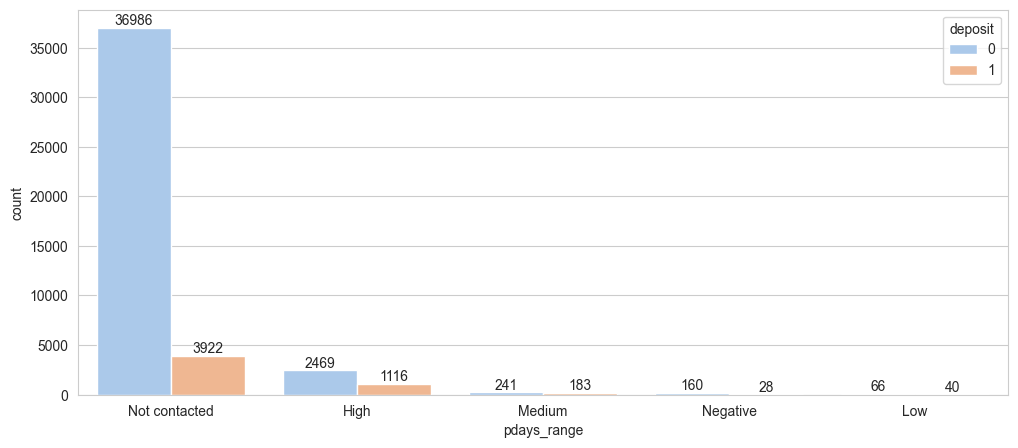

In [88]:
label(df,'pdays_range',12,5)

In [89]:
Ratio('pdays_range')

,Nr of Client,DeptSum,Ratio
pdays_range,,,
Medium,424,183,0.431604
Low,106,40,0.377358
High,3585,1116,0.311297
Negative,188,28,0.148936
Not contacted,40908,3922,0.095874


- After 60-90 days from the last contact of previous campaign, customers tend to accept the offer to subscribe when they are contacted again in the current campaign.


- If customers are never contacted, they will be likely to reject the subscription.

# previous

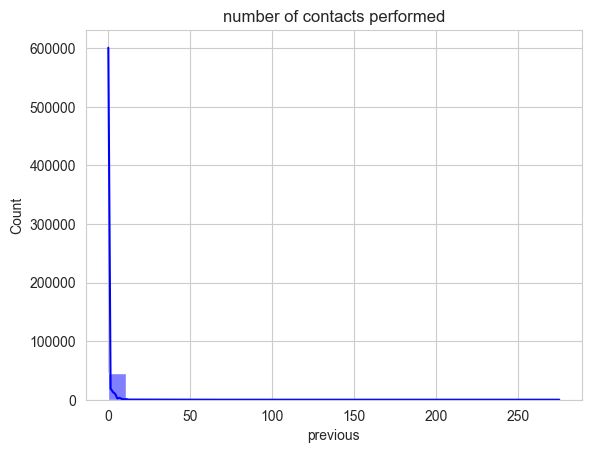

In [90]:
# number of contacts performed before this campaign and for this client 
sns.histplot(data=df, x='previous', kde = True, legend=True, bins=25, color ='b')
plt.title('number of contacts performed')
plt.xlabel('previous')
plt.show()

In [91]:
bins = [-1,0,1,5,20,50,100,275]
labels =['0','1','2-5','6-20','21-50','51-100','101-']
df['binned_previous'] = pd.cut(df['previous'], bins,labels=labels)
Ratio('binned_previous')

,Nr of Client,DeptSum,Ratio
binned_previous,,,
51-100,3,2,0.666667
6-20,1009,272,0.269574
2-5,4421,1042,0.235693
1,2772,583,0.210317
21-50,51,6,0.117647
0,36954,3384,0.091573
101-,1,0,0.000000


- Customers who got about 51-100 contacts from previous campaigns tend to agree with the subscription, but the number of customer is only 3, while others with no contacts tend to refuse the deposit; About more than 100 contacts, this values could be outliers